Import the libraries necessary to analize data

In [660]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [661]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

Since in the TASK 3, we need to define a boolean variable representing the class, we decide to pre-calculate it together also with other classes involving injury, arrest, survivors to label the PCA results after the normalization and see how they are distributed

In [662]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0) 
df['involve_injury'] = np.where(df['n_injured'] > 0, 1, 0) 
df['involve_arrest'] = np.where(df['n_arrested'] > 0, 1, 0) 
df['is_survived'] = np.where(df['n_unharmed'] > 0, 1, 0) 

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [663]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'involve_injury', 'involve_arrest','is_survived'
       ]
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)

In [664]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]
numeric_attributes

['povertyPercentage',
 'incident_gravity',
 'females_rate',
 'minor_rate',
 'arrested_rate',
 'survival_rate',
 'winning_party_percentage',
 'killed_rate',
 'injured_rate',
 'killed_disp_per_district',
 'injured_disp_per_district',
 'part_disp_per_district']

In [665]:
df[numeric_attributes].describe()

,povertyPercentage,incident_gravity,females_rate,minor_rate,arrested_rate,survival_rate,winning_party_percentage,killed_rate,injured_rate,killed_disp_per_district,injured_disp_per_district,part_disp_per_district
count,187534.00000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000,187534.000000
mean,12.67013,0.749677,0.089360,0.069669,0.248404,0.176173,0.681677,0.163842,0.303845,0.999435,0.999808,1.000000
std,2.71095,0.796298,0.228503,0.230677,0.386724,0.326824,0.130526,0.328084,0.410233,2.291665,1.612196,0.757341
min,5.60000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.90000,0.000000,0.000000,0.000000,0.000000,0.000000,0.597980,0.000000,0.000000,0.000000,0.000000,0.600629
50%,12.40000,1.000000,0.000000,0.000000,0.000000,0.000000,0.668029,0.000000,0.000000,0.000000,0.000000,0.742533
75%,14.20000,1.000000,0.000000,0.000000,0.500000,0.250000,0.749041,0.000000,0.500000,0.000000,1.748387,1.294219
max,20.80000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.500000,60.000000,43.510033


In [666]:
# To reduce variance, appliable to positive values
attr_to_log = ['avg_age_participants']#, 'survival_rate','killed_rate',	'injured_rate',	'arrested_rate']
df[attr_to_log] = np.log(df[attr_to_log].values)
df[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)
df[attr_to_log] = df[attr_to_log].fillna(value=0) 

C:\Users\mitol\AppData\Local\Temp\ipykernel_7532\2173104921.py:3: RuntimeWarning: divide by zero encountered in log
  df[attr_to_log] = np.log(df[attr_to_log].values)


In [667]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          187534 non-null  float64
 1   incident_gravity           187534 non-null  float64
 2   females_rate               187534 non-null  float64
 3   minor_rate                 187534 non-null  float64
 4   arrested_rate              187534 non-null  float64
 5   survival_rate              187534 non-null  float64
 6   winning_party_percentage   187534 non-null  float64
 7   killed_rate                187534 non-null  float64
 8   injured_rate               187534 non-null  float64
 9   killed_disp_per_district   187534 non-null  float64
 10  injured_disp_per_district  187534 non-null  float64
 11  part_disp_per_district     187534 non-null  float64
dtypes: float64(12)
memory usage: 17.2 MB


## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [668]:
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

## PCA

We do the PCA analysis to visualize in 2D the distribution of our multi-dimensional data

In [669]:
scaled_df[column_to_drop] = df[column_to_drop]

In [670]:
pca = PCA(n_components=2)

In [671]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

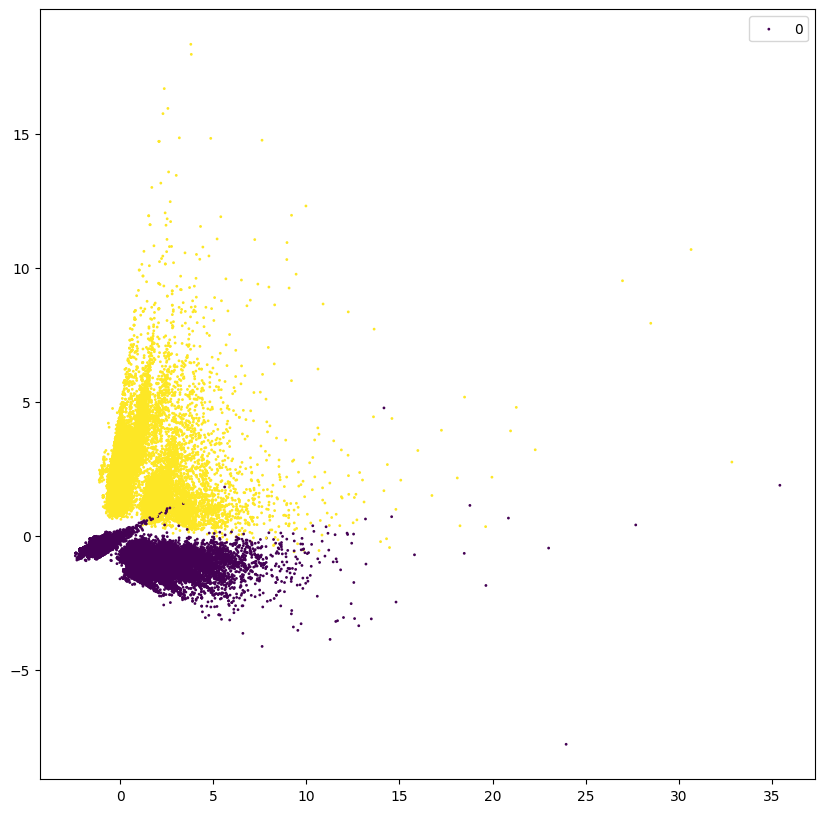

In [680]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_killing'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
plt.legend(scaled_df['involve_killing'].unique())

# display the plot
plt.show()

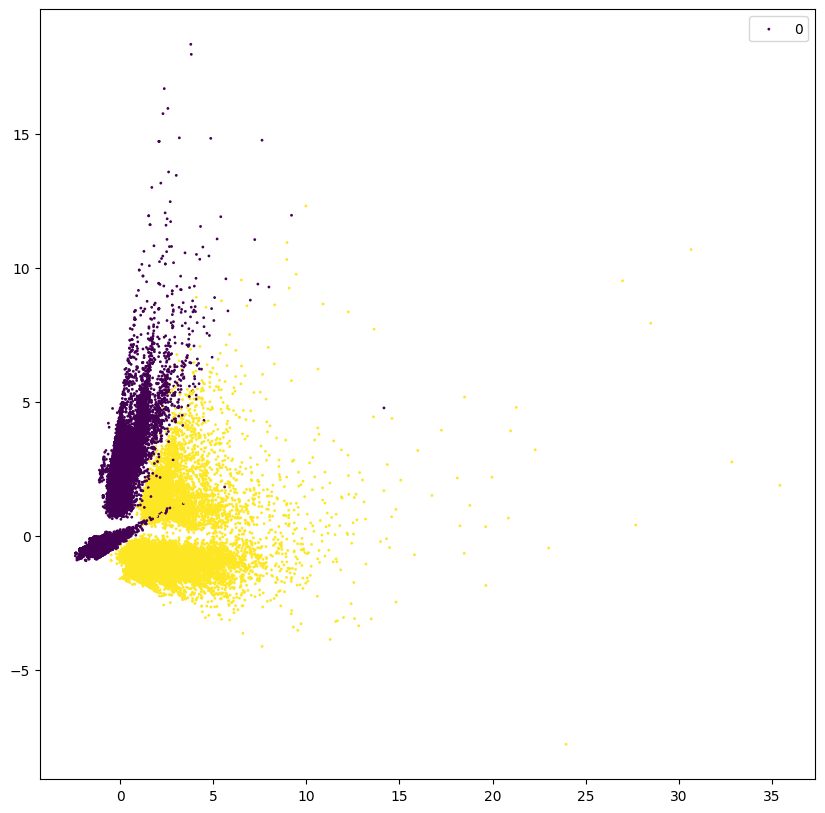

In [678]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_injury'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
plt.legend(scaled_df['involve_injury'].unique())

# display the plot
plt.show()

## Saving the normalized dataset

In [674]:
scaled_df.to_csv('df_scaled.csv', index=False)